In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import umap
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
#pip install umap

In [2]:
import sys
sys.executable

'/home/giorgos/anaconda3/bin/python'

In [3]:
! pip install cloudpickle --upgrade
! pip install tensorflow --upgrade
! pip install keras --upgrade
! pip install umap-learn


Requirement already up-to-date: cloudpickle in /home/giorgos/anaconda3/lib/python3.7/site-packages (1.6.0)
Requirement already up-to-date: tensorflow in /home/giorgos/anaconda3/lib/python3.7/site-packages (2.3.1)
Requirement already up-to-date: keras in /home/giorgos/anaconda3/lib/python3.7/site-packages (2.4.3)


In [4]:
sample_submission = pd.read_csv("~/Documents/R/Kaggle/lish_moa/sample_submission.csv")



## Train Data Preprocess

In [5]:
train_features = pd.read_csv("~/Documents/R/Kaggle/lish_moa/train_features.csv")
train_targets_scored = pd.read_csv("~/Documents/R/Kaggle/lish_moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("~/Documents/R/Kaggle/lish_moa/train_targets_nonscored.csv")

In [6]:
# join train_features and non_scored_forTrain
non_scored = pd.merge(train_targets_nonscored,train_features,on="sig_id", how="inner")        

In [7]:
score ={"score":non_scored.iloc[:,1:403].sum(axis=1)}

In [8]:
score=pd.DataFrame(data = score)
non_scored = pd.concat([non_scored,score],axis=1)
non_scored = non_scored[non_scored["score"]>0]

In [9]:
non_scored_forTrain = pd.concat([non_scored.iloc[:,0],non_scored.iloc[:,403:1278]],axis=1)

In [10]:
train_features = pd.concat([train_features, non_scored_forTrain])

In [11]:
train_features_labels = pd.merge(train_features,train_targets_nonscored, how="left", on="sig_id")
train_features_labels = pd.merge(train_features,train_targets_scored, how="left", on="sig_id")

In [12]:
train_features_labels

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28399,id_ffaac2669,trt_cp,48,D2,0.9666,0.8059,1.3720,0.1972,0.1620,-0.5821,...,0,0,0,0,0,0,0,0,0,0
28400,id_ffab8a71d,trt_cp,72,D2,-0.3375,-1.2220,-0.5480,0.5279,-0.3146,0.2511,...,0,0,0,0,0,0,0,0,0,0
28401,id_ffdd24c81,trt_cp,72,D2,-1.1810,-0.5206,0.0939,0.2877,-0.8058,0.3327,...,0,0,0,0,0,0,0,0,0,0
28402,id_fff26b3c2,trt_cp,24,D2,0.3480,0.8765,-0.7967,-0.3478,-0.1713,0.0767,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Features
train_features = train_features_labels.iloc[:,1:876]
train_features.shape

(28404, 875)

In [14]:
# Labels
train_labels = train_features_labels.iloc[:,876:1082]
train_labels.shape

(28404, 206)

# Create PCA model 


## PCA train data

In [15]:
#sns.pairplot(train_features.iloc[1:500,5:20])


In [16]:
pca = PCA(n_components=3)


In [23]:
def modelPca(n_components = 5,
              test_size = 0.85,
              units = 256,
              optmz = "adamax",
              epochs = 100,
              batch = 64,
              lr_rate =0.1,
              patience = 5,
              Dropout_rate = 0.5,
              random_state = 42):
    
    """HyperTune umapDeapLearning"""
    
    reducer = PCA(n_components=n_components,random_state = random_state)
    
    features_for_pca = train_features.iloc[:,3:]
    train_pca = reducer.fit_transform(features_for_pca)
    train_pca.shape
    train_features["cp_time"]=train_features["cp_time"].astype(str)
    dummies_train = train_features.iloc[:,0:3]
    dummies_train = pd.get_dummies(data=dummies_train,drop_first=True)
    train_features_pca_dummies = pd.concat([pd.DataFrame(data=train_pca),dummies_train],axis=1)
    test_size = test_size
    X_train, X_test, y_train, y_test = train_test_split(train_features_pca_dummies.to_numpy(),
                                                        train_labels.to_numpy(),
                                                        test_size = test_size, 
                                                        random_state=42)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=lr_rate,
                                  patience=patience)#, min_lr=0.001)
    callback_list = [reduce_lr]
    
    global model
    model = Sequential(
    [
    layers.Dense(units, activation = 'relu', input_shape=(train_features_pca_dummies.to_numpy().shape[1],)),
    layers.Dropout(rate = Dropout_rate),
    layers.Dense(units, activation = 'relu'), 
    layers.Dropout(rate = Dropout_rate),
    layers.Dense(units = train_labels.shape[1], activation = 'sigmoid')
    ]    
    )

    #model.summary()
    model.compile(
    optimizer = optmz,
    loss = "binary_crossentropy",
    metrics = ["accuracy"])

    history = model.fit(
        X_train, y_train,
        epochs = epochs,
        batch_size = batch,
        callbacks = callback_list,
        validation_data=(X_test,y_test),
        verbose=0
    )

    # list all data in history
    #print(history.history.keys())
    global valLoss
    valLoss = round(np.min(history.history["val_loss"]),6)
    print("best val_loss:", round(np.min(history.history["val_loss"]),6))
    print("best loss:", round(np.min(history.history["loss"]),6))

    plt.figure(figsize = (10,6))
    plt.rc_context({'xtick.color':'white', 'ytick.color':'white'})
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.figure(figsize = (10,6))
    plt.rc_context({'xtick.color':'white', 'ytick.color':'white'})
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

best val_loss: 0.017591
best loss: 0.017683


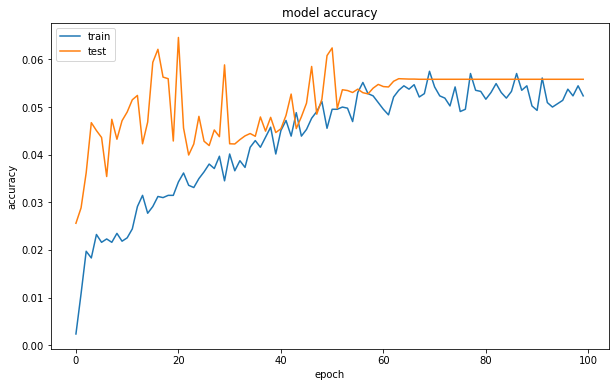

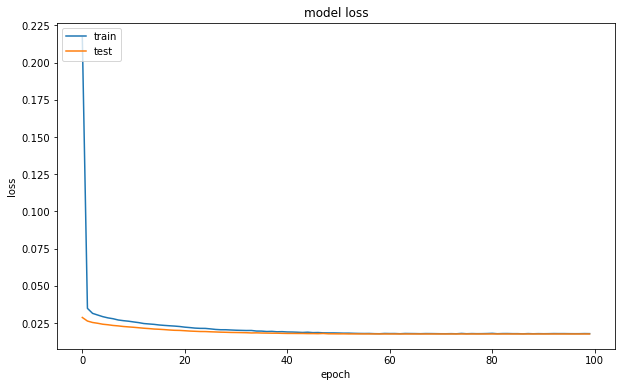

In [24]:
modelPca()

## Find best hyperparametrs

In [45]:
#total_val_loss = pd.DataFrame()
total_val_loss = pd.read_csv("total_val_loss_PcaSearch.csv")

n_components = [50,75,80,82,100,"mle"]


0 # n_componets:  50
best val_loss: 0.016328
best loss: 0.015667


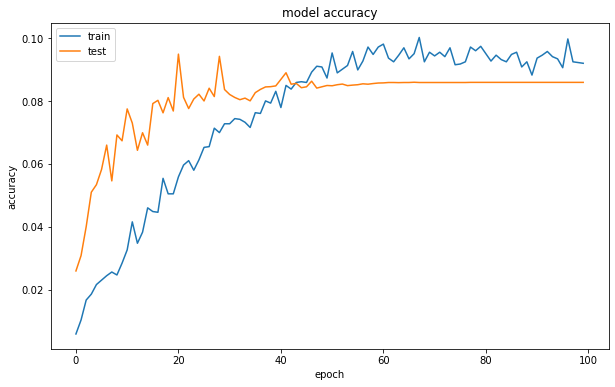

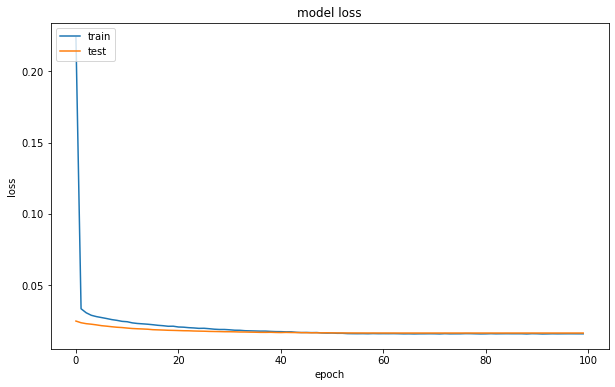

###############################################################################
1 # n_componets:  75
best val_loss: 0.016176
best loss: 0.014934


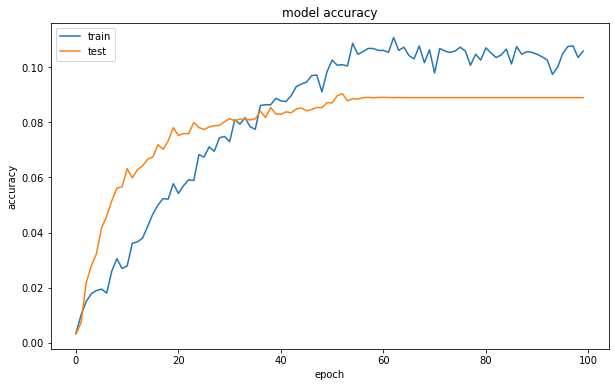

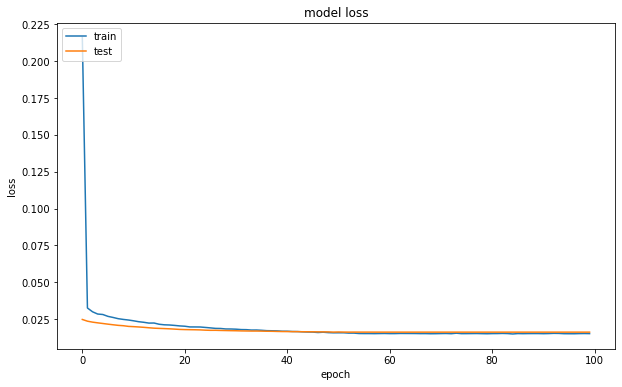

###############################################################################
2 # n_componets:  80
best val_loss: 0.01603
best loss: 0.014338


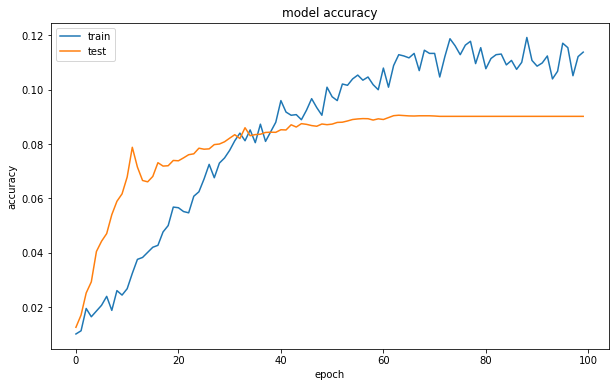

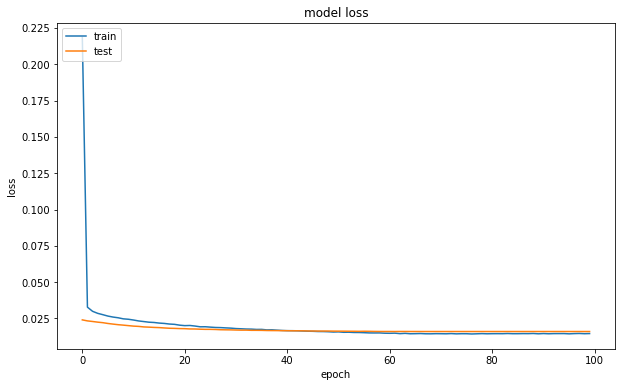

###############################################################################
3 # n_componets:  82
best val_loss: 0.016158
best loss: 0.014833


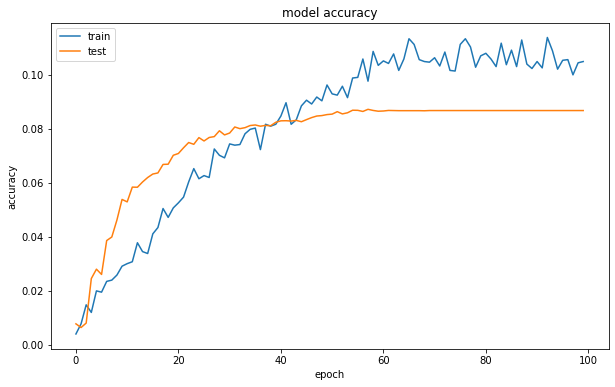

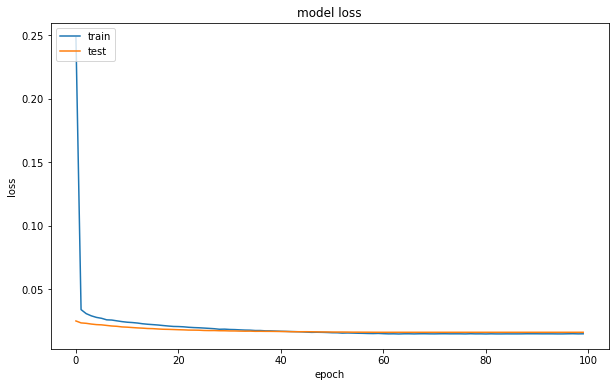

###############################################################################
4 # n_componets:  100
best val_loss: 0.016242
best loss: 0.014656


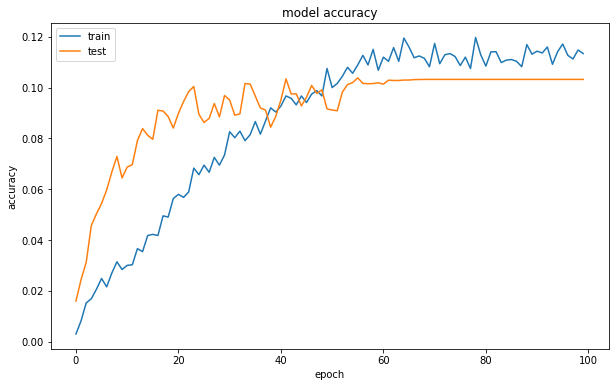

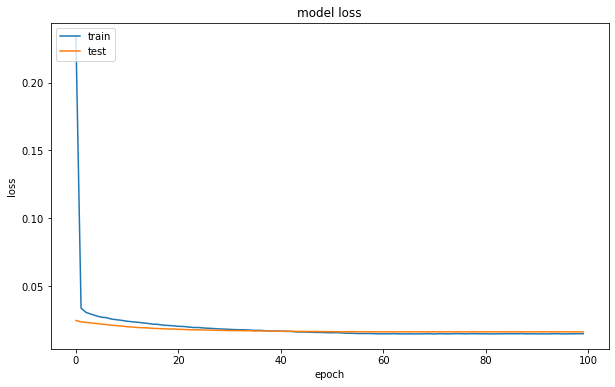

###############################################################################
5 # n_componets:  mle
best val_loss: 0.017067
best loss: 0.011386


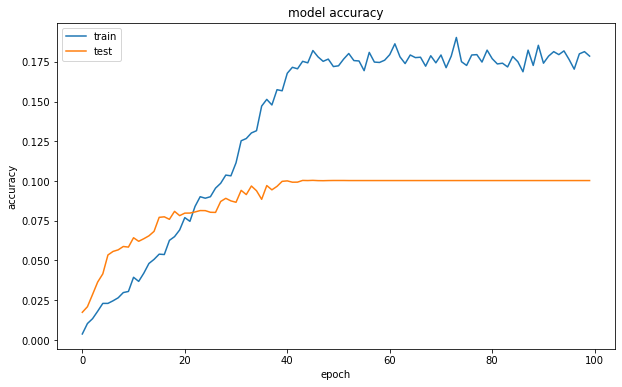

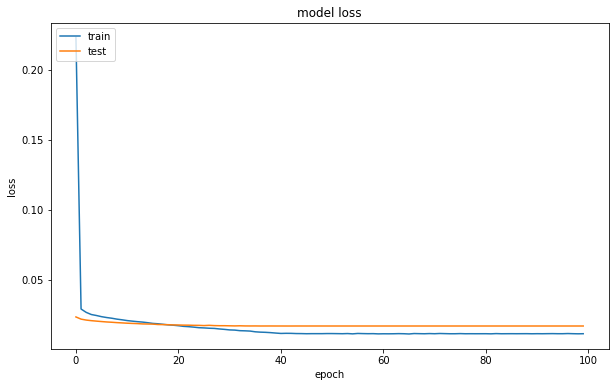

###############################################################################


In [46]:
for c in range(0, len(n_components),1):
    print(c,"# n_componets: ",n_components[c])
    
    modelPca(n_components=n_components[c])
    kouvas = pd.DataFrame(data = {'n_components': n_components[c],'val_loss':valLoss},index=[0])
    total_val_loss = pd.concat([total_val_loss,kouvas],axis=0)
    total_val_loss.to_csv("total_val_loss_PcaSearch.csv")
    print("###############################################################################")


In [47]:
total_val_loss.sort_values(by = ["val_loss"])


,n_components,val_loss
0,80,0.016030
0,82,0.016158
0,75,0.016176
0,100,0.016242
0,50,0.016328
0,mle,0.017067


/home/giorgos/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


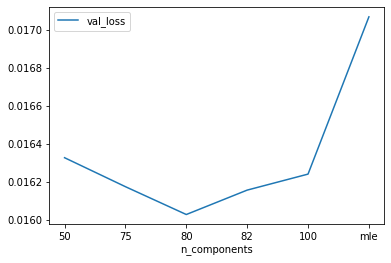

In [48]:
total_val_loss.plot(x="n_components",y="val_loss")
plt.show()